In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

file_path = '../data/processed/Juegorawg_limpio.csv'
df = pd.read_csv(file_path)
df.copy()

df["playtime_log"] = np.log1p(df["playtime"])  # Transformación logarítmica

# Calcular cuartiles
Q1 = df["playtime_log"].quantile(0.25)
Q3 = df["playtime_log"].quantile(0.75)

# Función para clasificar
def categorize_playtime(x):
    if x < Q1:
        return "Bajo"
    elif Q1 <= x <= Q3:
        return "Medio"
    else:
        return "Alto"

df["playtime_category"] = df["playtime_log"].apply(categorize_playtime)

# Convertir categorías de texto a valores numéricos
label_encoder = LabelEncoder()
df["playtime_category"] = label_encoder.fit_transform(df["playtime_category"])

'''Variable Objetivo'''

X = df.drop(columns=["playtime", "playtime_log", "playtime_category", "slug", "name", "updated"])
y = df["playtime_category"]


X = pd.get_dummies(X, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Definir el modelo base XGBoost

In [9]:
xgb_clf = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', random_state=42)


In [10]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.1, 1]
}

# Búsqueda de hiperparámetros con RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


In [11]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           num_class=3, num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200],
                                        'reg_alpha': [0, 0.01, 0.1, 1],
                                        'reg_lambda': [0, 0.01, 0.1, 1],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [12]:
# Mejor modelo
best_xgb = random_search.best_estimator_

# Realizar predicciones con el mejor modelo
y_pred = best_xgb.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


In [13]:
# Imprimir resultados
print(f"Mejores hiperparámetros: {random_search.best_params_}")
print(f"Exactitud del modelo: {accuracy:.2f}")
print("Reporte de Clasificación:")
print(report)

Mejores hiperparámetros: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
Exactitud del modelo: 0.78
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.55      0.10      0.17       169
           1       0.79      0.98      0.87       585

    accuracy                           0.78       754
   macro avg       0.67      0.54      0.52       754
weighted avg       0.74      0.78      0.72       754



In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

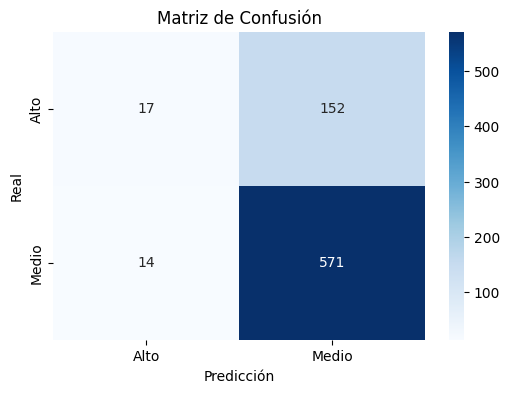

<Figure size 800x600 with 0 Axes>

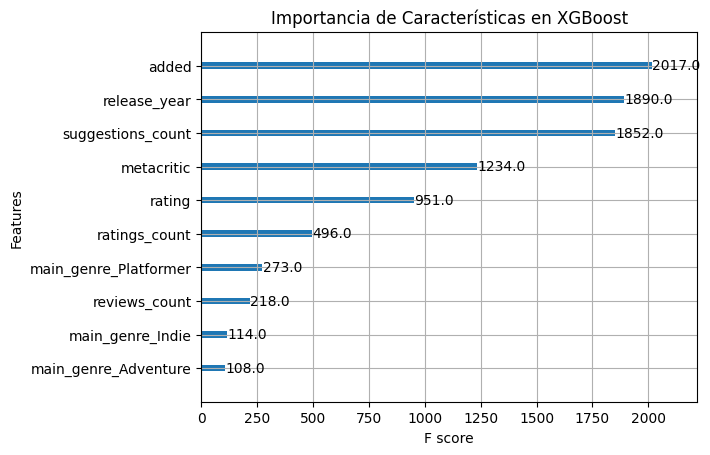

In [17]:
# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Importancia de Características
plt.figure(figsize=(8,6))
plot_importance(best_xgb, max_num_features=10)
plt.title('Importancia de Características en XGBoost')
plt.show()